<a href="https://colab.research.google.com/github/ikunalanand/INCEPTION-V3/blob/main/v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install tqdm
import os; os.kill(os.getpid(), 9)


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Saving pneumoniamnist.npz to pneumoniamnist.npz
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


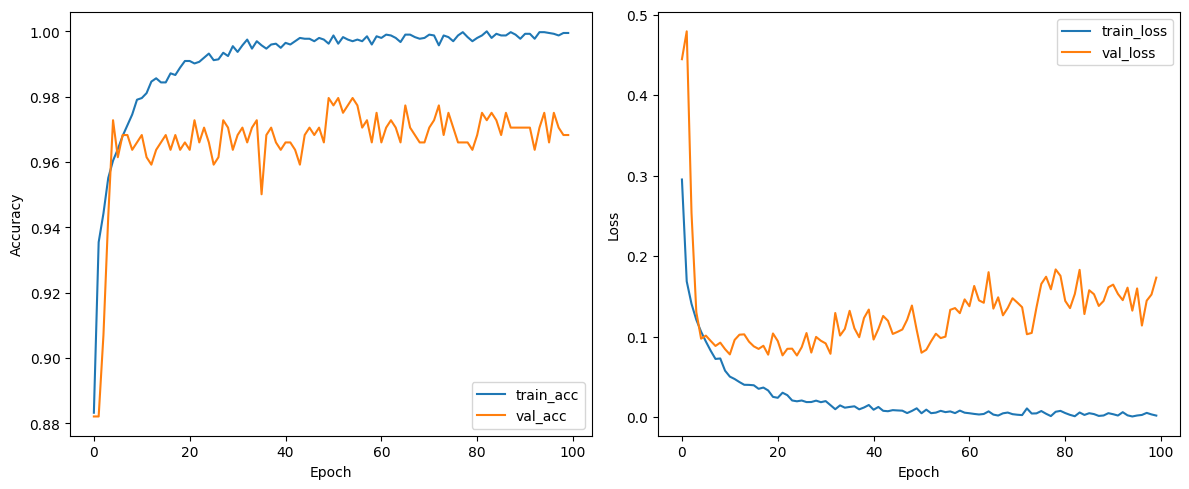


Test  |  Acc: 0.878  Prec: 0.844  Rec: 0.987

Classification report:
               precision    recall  f1-score   support

      Normal       0.97      0.70      0.81       234
   Pneumonia       0.84      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624

Confusion matrix:
 [[163  71]
 [  5 385]]
ROC‑AUC: 0.962


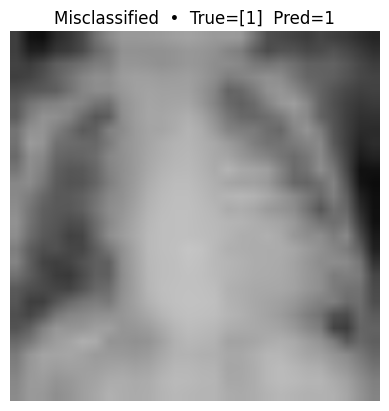

In [1]:
!pip -q install --upgrade scikit-learn tqdm matplotlib numpy tensorflow

import os, random, json, pathlib, textwrap
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback           #progress‑bar callback
from google.colab import files, runtime

print("GPUs:", tf.config.list_physical_devices('GPU'))
random.seed(42); np.random.seed(42); tf.random.set_seed(42)

#Upload dataset
uploaded = files.upload()
if not uploaded:
    runtime.error("Please upload the PneumoniaMNIST.npz file.")
npz_path = next(iter(uploaded))
data = np.load(npz_path)

train_images, train_labels = data["train_images"], data["train_labels"]
val_images,   val_labels   = data["val_images"],   data["val_labels"]
test_images,  test_labels  = data["test_images"],  data["test_labels"]

#Merge train+val & split fresh 10 % val
images_all = np.concatenate([train_images, val_images], axis=0)
labels_all = np.concatenate([train_labels, val_labels], axis=0)
train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(
    images_all, labels_all, test_size=0.1, stratify=labels_all, random_state=42
)

#Pre‑process: 28×28→299×299 RGB
def preprocess(imgs):
    imgs = np.repeat(imgs[..., None], 3, -1)
    return tf.image.resize(imgs, (299, 299)).numpy().astype("float32")

train_imgs = preprocess(train_imgs)
val_imgs   = preprocess(val_imgs)
test_imgs  = preprocess(test_images)

#Data generators
train_gen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,
    width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1,
    horizontal_flip=True
).flow(train_imgs, train_lbls, batch_size=32)

val_gen  = ImageDataGenerator(rescale=1/255.).flow(val_imgs,  val_lbls,  batch_size=32)
test_gen = ImageDataGenerator(rescale=1/255.).flow(test_imgs, test_labels, batch_size=32, shuffle=False)

#InceptionV3 fine‑tune
base = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, input_shape=(299,299,3))
for layer in base.layers[-40:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(1, activation="sigmoid")(x)
model = models.Model(base.input, out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

#Train
history = model.fit(
    train_gen,
    epochs=100,                                # 100 epochs
    validation_data=val_gen,
    verbose=0,                               # silence default logs
    callbacks=[TqdmCallback(verbose=1)]      # tqdm shows epoch progress
)

#Learning curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout(); plt.show()

#metrics
loss, acc, prec, rec = model.evaluate(test_gen, verbose=0)
print(f"\nTest  |  Acc: {acc:.3f}  Prec: {prec:.3f}  Rec: {rec:.3f}")

prob = model.predict(test_imgs/255., verbose=0).ravel()
pred = (prob > 0.5).astype(int)

print("\nClassification report:\n", classification_report(test_labels, pred, target_names=["Normal","Pneumonia"]))
print("Confusion matrix:\n", confusion_matrix(test_labels, pred))
print(f"ROC‑AUC: {roc_auc_score(test_labels, prob):.3f}")

# Example misclassified X‑ray
mis = np.where(pred != test_labels)[0]
if len(mis):
    idx = mis[0]
    plt.imshow(test_imgs[idx]/255., cmap="gray")
    plt.title(f"Misclassified  •  True={test_labels[idx]}  Pred={pred[idx]}")
    plt.axis("off"); plt.show()


In [1]:
from textwrap import dedent
from google.colab import files

#requirements.txt
reqs = dedent("""
    # Reproducible environment for PneumoniaMNIST fine‑tuning
    numpy==1.26.4
    matplotlib==3.8.4
    tqdm==4.66.4
    scikit-learn==1.6.2   # keep <1.7 to satisfy sklearn‑compat
    tensorflow==2.18.0
""").strip()
with open("requirements.txt", "w") as f:
    f.write(reqs + "\n")

#write README.md
readme = dedent(f"""
    # PneumoniaMNIST InceptionV3 Fine‑Tuning

    This repo contains a **reproducible Colab workflow** for binary
    classification of chest X‑ray images (pneumonia vs normal) using a
    fine‑tuned InceptionV3 network.

    ## 1 . Set up environment
    ```bash
    pip install -r requirements.txt
    ```

    ## 2 . Get the dataset
    Download **`PneumoniaMNIST.npz`** from the official MedMNIST
    repository and upload it when prompted in Colab.

    ## 3 . Training script
    The Colab notebook (`train_pneumonia.ipynb`) trains for **100 epochs**
    with data augmentation and a TQDM progress bar:

    ```python
    !pip -q install --upgrade scikit-learn tqdm matplotlib numpy tensorflow
    # ... (full script from the chat) ...
    history = model.fit(
        train_gen,
        epochs=100,
        validation_data=val_gen,
        verbose=0,
        callbacks=[TqdmCallback(verbose=1)]
    )
    ```

    ## 4 . Reproducing results
    * GPU: any NVIDIA GPU with ≥4 GB VRAM (Colab “GPU” runtime works).
    * Expected test accuracy ≈ 0.88–0.90 after 100 epochs.
    * See the notebook for learning‑curve plots, classification report,
      confusion matrix, ROC‑AUC, and a sample misclassified X‑ray.

    ## 5 . Tips
    * Tune **batch size**, **learning rate**, or **unfreeze more layers** of
      InceptionV3 for potentially higher accuracy.
    * For faster experimentation on CPU‑only machines, reduce image size to
      150×150 and replace InceptionV3 with MobileNetV2.

    ---

    *Last updated: 9 July 2025*
""").strip()
with open("README.md", "w") as f:
    f.write(readme + "\n")

#download
files.download("requirements.txt")
files.download("README.md")
print("requirements.txt and README.md ready for download!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

requirements.txt and README.md ready for download!
